In [1607]:
import numpy as np
import netCDF4

from scipy import (special, signal, ndimage)
from scipy.ndimage import gaussian_filter

from ipywidgets import (interact)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

plt.rcParams['figure.figsize'] = (25, 10)

import os
from pathlib import Path

In [1608]:
from box import Box, DataSet
from units import unit
from plotting import (plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot)

# Data

In [1609]:
data_folder = Path("/mnt/D_DRIVE/CMIP5/data_duplicate")
data_set = DataSet(
    path=data_folder,
    # model='HadGEM2-ES',
    # variable='mrso',
    model = 'MPI-ESM-LR',
    variable = 'tas',
    scenario='rcp85',
    realization='r1i1p1'
)

data_set.load()

## Load the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [1610]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.0833314 year, 207.379 km, 208.49 km) per pixel
2006-01-16, 2006-02-15, 2006-03-16,  ...
time steps: max 31.0 min 29.5


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

In [1611]:
yearly = box[::12]
print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*yearly.resolution))
for t in yearly.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

(0.999981 year, 207.379 km, 208.49 km) per pixel
2006-01-16, 2007-01-16, 2008-01-16,  ...


# Parameter settings

In [1633]:
# SEB: I moved these parameter definitions after data loading for the moment, because then we don't need to load the data 
# every time we try new parameter values. Does not seem to make it much faster though...
######
month=3  # good to have this parameter here on top.

sigma_d = unit('200 km')
sigma_t = unit('5 year')


# aspect ratio for phase space 

sobelscale=1  # SEB: this is just to ensure that results are independent of sobelscale. 
# Interestingly, they are (although there are more space dimensions than time dimensions)

scaling_factor = unit('10 km/year')
sigma_d_sobel = unit('1000 km') * sobelscale
sigma_t_sobel = unit('100 year') * sobelscale

sobel_weights = [1 * sigma_t_sobel, 1 * sigma_d_sobel, 1 * sigma_d_sobel]

#SEB:
#sobel_weights = [1 , 1 , 1]  # fails due to dimensionality error - is this because physical units are expected?

# replace the Sobel weighting with data standardisation (based on the standard deviation of the derivatives in each dimension)
# may use z_scores, thus rescaling the data based on its own variance; then give equal weight to the dimensions
# alternative: it might be better to use min-max scaling because spatial gradients are locally (at edges of continents or mountains) 
#much bigger than the typical value (i.e. distribution of gradients has very long tails)
# standardising should be done after smoothing the data and after taking the derivatives because the problem mainly seems
# to arise from the different physical units, not from the typical temperature differences in space and time (which are similar)

################

In [1634]:
#plot_mollweide(box, data_set.data[0])

In [1635]:
#plot_orthographic_np(box, data_set.data[150*12] - data_set.data[0])

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [1636]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [1637]:
data = data_set.data[month-1::12]
yearly_box = box[month-1::12]

smooth_data = yearly_box.gaussian_filter(data, [sigma_t, sigma_d, sigma_d])

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [1638]:
sb = yearly_box.sobel_filter(smooth_data, weight=sobel_weights)

In [1639]:
## SEB: try standardising here

# sb.shape   # returns (4, 295, 96, 192)  =>    3 gradients (time, space, space), and 1 signal strength, 295 longitudes, 96 latitudes, 192 years
                                              # the sum of the squared gradients is 1

# divide time derivatives with std (or max) of all time derivatives (considering all time and space points)
# do the same for space in general (not distinguishing lon and lat in this case)

#sb[:,150,70,50]
# result:  # array([ 0.80601174, -0.5843994 , -0.09392808,  0.0632038 ], dtype=float32)
## all 4 numbers depend on the sobel weights. here: 1000km, 100yrs
# when given more weight on time, first entry is almost 1.


# probably also need to rescale the signal => run sobel filter twice, or break down in 2 steps?!


### Determine proper hysteresis settings

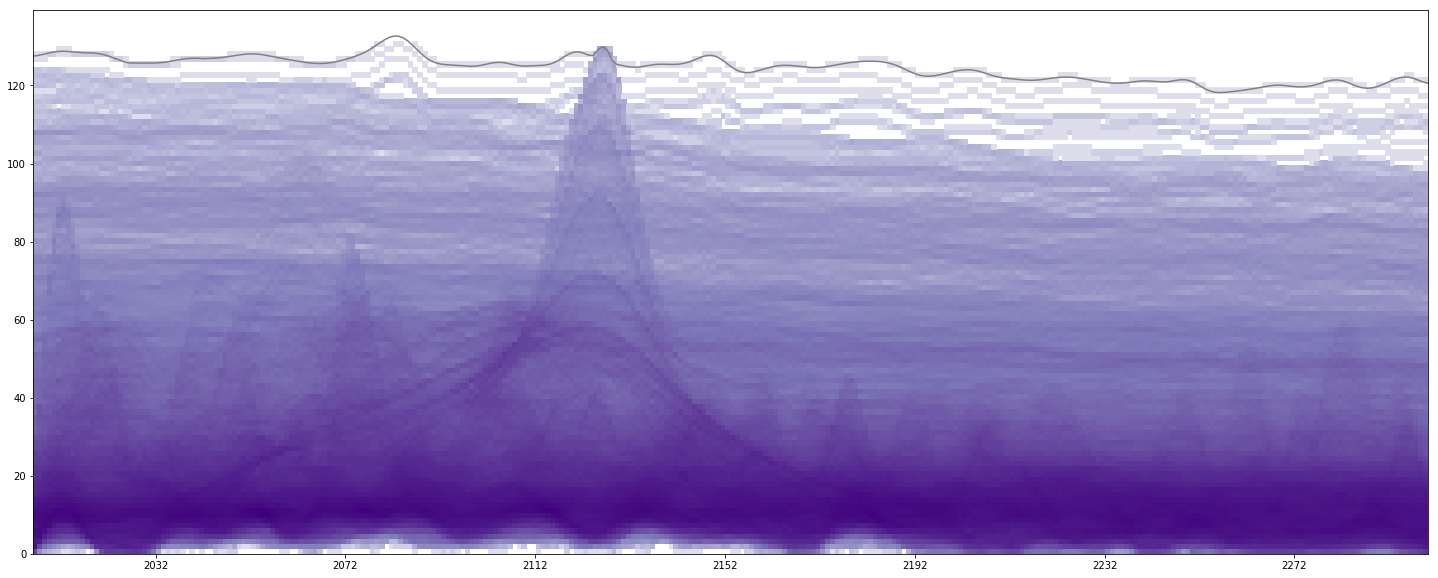

In [1640]:
### SEB: we could add negative values in the plot, like for piControl below

signal = 1.0 / sb[3]

# flatten sobel signal
n_years = yearly_box.shape[0]
signal_flat = signal.reshape([n_years, -1])

# create bins for histograms
n_bins = 100
bins = np.linspace(signal.min(), signal.max(), n_bins+1)

# generate histogram for each time step
hist = np.zeros(shape=(n_years, n_bins))
for t in range(n_years):
    h, _ = np.histogram(signal_flat[t], bins=bins)
    hist[t, :] = h

# plot
plt.pcolormesh(yearly_box.dates, bins[:-1], hist.T,
               norm=colors.LogNorm(vmin=0.1, vmax=hist.max()),
               cmap='Purples')
plt.plot(yearly_box.dates, signal_flat.max(axis=1), '-', c='gray')
plt.show()

In [1641]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [1642]:
dat = sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])

In [1643]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/(30*sobelscale), b=1/(15*sobelscale))
m = edges.transpose([2, 1, 0])

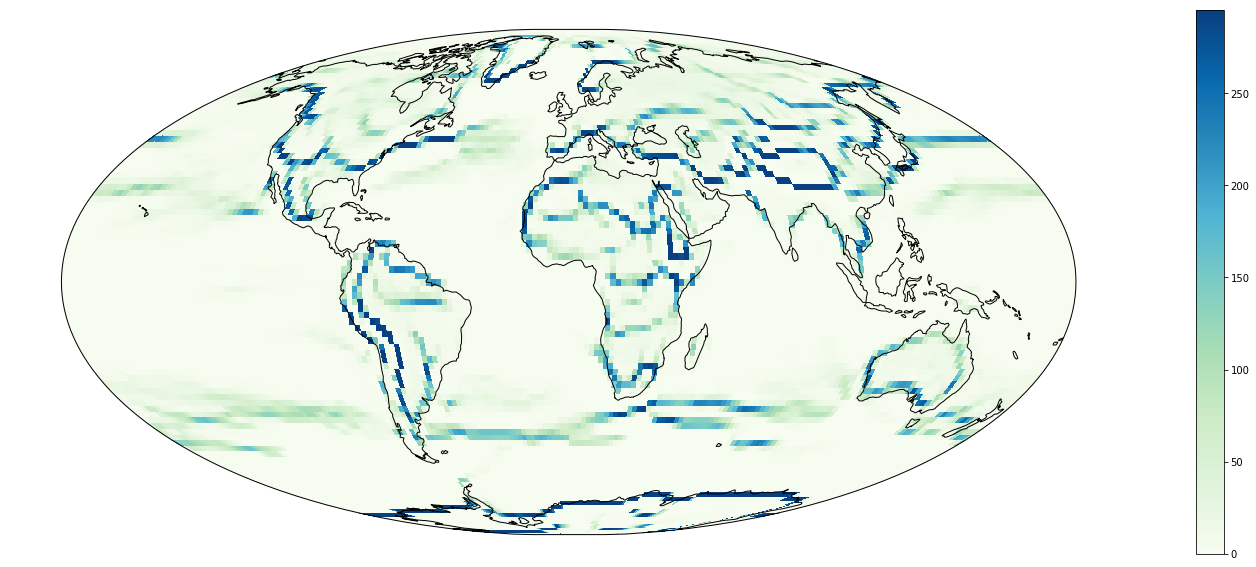

In [1644]:
plot_mollweide(yearly_box, m.sum(axis=0), cmap='GnBu')

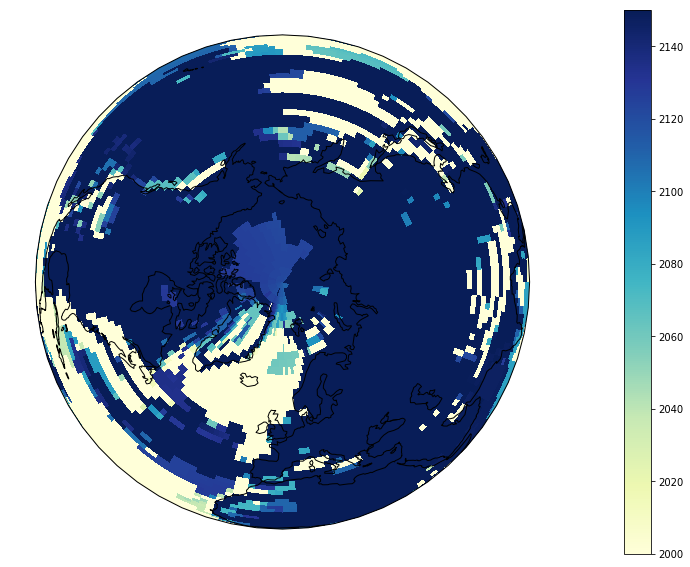

In [1645]:
years = np.array([d.year for d in yearly_box.dates])
plot_orthographic_np(yearly_box, (years[:,None,None]*m).max(axis=0),  cmap='YlGnBu', vmin=2000, vmax=2150)

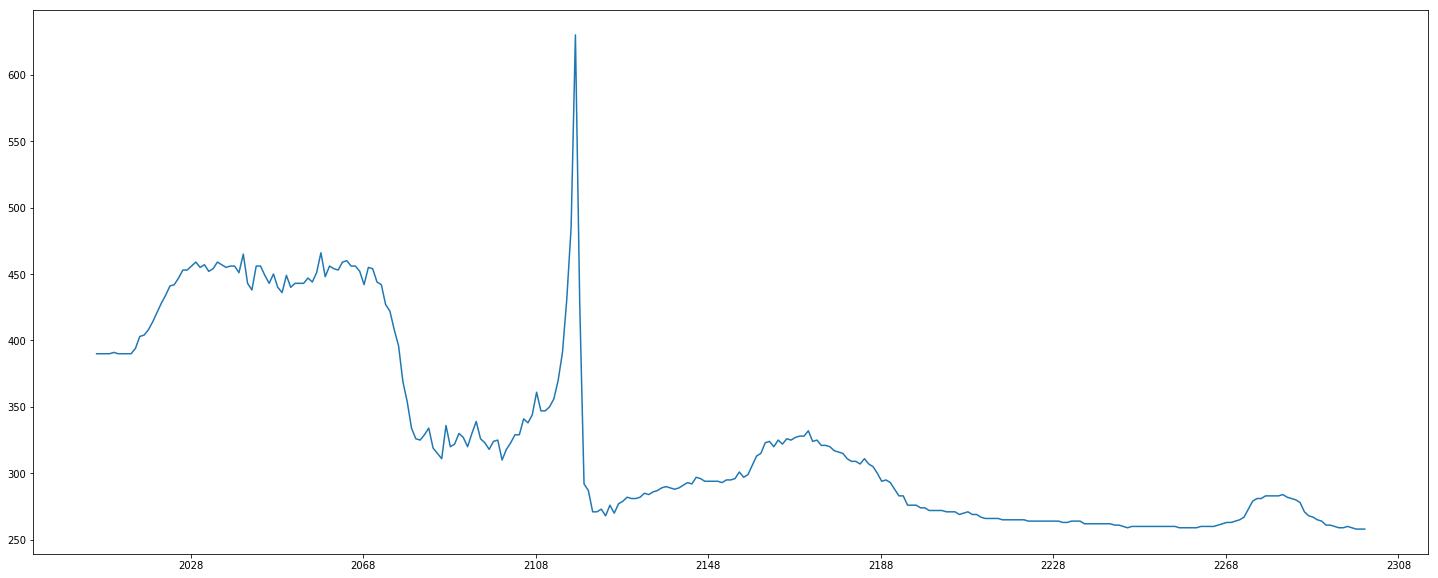

In [1625]:
plt.plot(yearly_box.dates, m.sum(axis=1).sum(axis=1))
plt.show()

# PI Control

In [1626]:
control_set = DataSet(
    path=data_folder, model='MPI-ESM-LR', variable='tas',
    scenario='piControl', realization='r1i1p1')
control_set.load()

In [1627]:
control_data = control_set.data[month-1::12]
yearly_box = control_set.box[month-1::12]

smooth_control_data = yearly_box.gaussian_filter(control_data, [sigma_t, sigma_d, sigma_d])
sbc = yearly_box.sobel_filter(smooth_control_data, weight=sobel_weights)

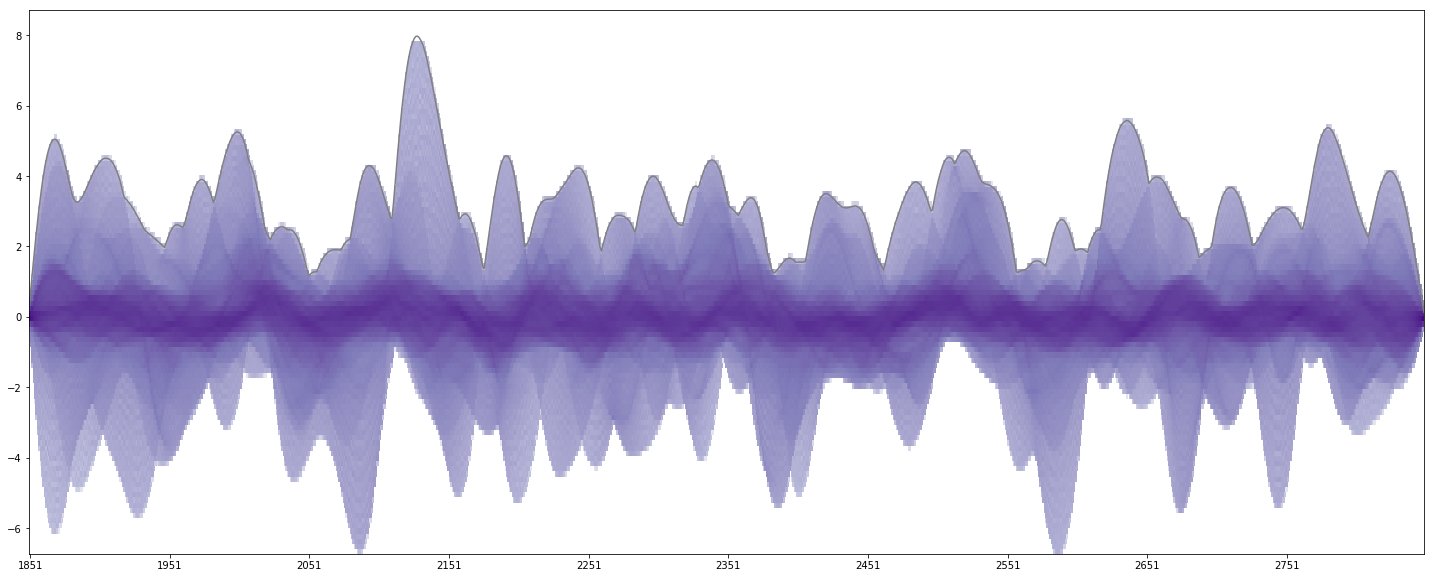

In [1628]:
signal = sbc[0]/sbc[3,:,:,:]

# flatten sobel signal
n_years = yearly_box.shape[0]
signal_flat = signal.reshape([n_years, -1])

# create bins for histograms
n_bins = 100
bins = np.linspace(signal.min(), signal.max(), n_bins+1)

# generate histogram for each time step
hist = np.zeros(shape=(n_years, n_bins))
for t in range(n_years):
    h, _ = np.histogram(signal_flat[t], bins=bins)
    hist[t, :] = h

# plot
plt.pcolormesh(yearly_box.dates, bins[:-1], hist.T,
               norm=colors.LogNorm(vmin=0.1, vmax=hist.max()),
               cmap='Purples')
plt.plot(yearly_box.dates, signal_flat.max(axis=1), '-', c='gray')
plt.show()

In [1629]:
# std = np.sqrt((sbc[0]/sbc[3]).var(axis=0) + (sb[1]/sb[3]).var(axis=0) + (sb[2]/sb[3]).var(axis=0))
std0 = (sbc[0] / sbc[3]).std(axis=0)
std1 = (sbc[1] / sbc[3]).std(axis=0)
std2 = (sbc[2] / sbc[3]).std(axis=0)

In [1630]:
#plot_mollweide(box, std1)

In [1631]:
#plot_mollweide(box, (sb[1]/sb[3]).std(axis=0))

In [1632]:
#plot_mollweide(box, (sb[2]/sb[3]).std() / std2)